# Utilizar Keras para construir y entrenar redes LSTM con series temporales

En este cuaderno, vamos a usar keras para construir una red LSTM que resuelva un problema de predicción en series temporales.

El problema que vamos a estudiar es el de predicción de ventas de gatos y peces mensualmente en miles de libras. Para este problema se nos da un año y un mes y tenemos que predecir el número de ventas.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

El siguiente paso es cargar nuestro conjunto de datos de entrenamiento como un `DataFrame` de Pandas. A continuación, podemos extraer la matriz `numpy` del `DataFrame` y convertir los valores enteros en valores de punto flotante, que son más adecuados para el modelado con una red neuronal.

            Year  Month  Total
Date                          
1986-01-01  1986      1   9034
1986-02-01  1986      2   9596
1986-03-01  1986      3  10558
1986-04-01  1986      4   9002
1986-05-01  1986      5   9239


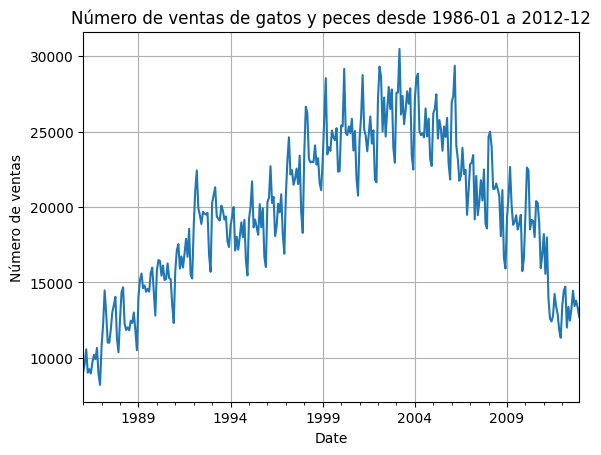

In [8]:
# Cargar el conjunto de datos usando pandas
# Leemos el dataset de catfish.csv

df = pd.read_csv('catfish.csv')
df.head()

# Convertimos 'Date' a datetime y extraemos año y mes
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Reordenamos columnas: Year, Month, luego todas las demás menos 'Total', y 'Total' al final
other_cols = [col for col in df.columns if col not in ['Year', 'Month', 'Total']]
df = df[['Year', 'Month'] + other_cols + ['Total']]

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)       # Convierte la fecha en el índice

print(df.head())

# Usar matplotlib para mostrar la serie
df["Total"].plot()
plt.title("Número de ventas de gatos y peces desde 1986-01 a 2012-12")
plt.ylabel("Número de ventas")
plt.grid(True)
plt.show()

# Fijar la semilla para reproducibilidad
numpy.random.seed(7)

Las redes LSTM pueden ser sensibles a la escala de los datos de entrada. Puede ser buena idea rescalar los datos en el rango [0,1]. Para ello, vamos a usar `MinMaxScaler`.

In [9]:
data = df['Total']
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data.values.reshape(-1,1))

Después de modelar nuestros datos y estimar su rendimiento en el conjunto de datos de entrenamiento, tenemos que hacernos una idea de su comportamiento con datos no vistos. Con los datos de series temporales, la secuencia de valores es importante. Un método sencillo que podemos utilizar es dividir el conjunto de datos ordenados en conjuntos de datos de entrenamiento y otro de test. El código siguiente calcula el índice del punto de división y separa los datos en conjuntos de datos de entrenamiento con el 67% de las observaciones que podemos utilizar para entrenar nuestro modelo, dejando el 33% restante para probar el modelo.

In [10]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Ahora vamos a definir una función que va a generar los datos para el entrenamiento de la LSTM.

La función toma dos argumentos: el conjunto de datos, que es un array de NumPy que queremos convertir en un conjunto de datos, y el look_back, que es el número de pasos de tiempo anteriores que se utilizarán como variables de entrada para predecir el siguiente período de tiempo - en este caso, por defecto, 1.

Este valor predeterminado creará un conjunto de datos donde X es el número de pasajeros en un momento dado (t) e Y es el número de pasajeros en el siguiente momento (t + 1).

De esta forma, estamos siguiendo la estrategia `one-to-one`.

In [11]:
# Convertir un array en un conjunto de datos
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

Ahora podemos utilizar esta función para preparar los conjuntos de datos de entrenamiento y test para el modelado.

In [12]:
look_back = 1
# Preparar el conjunto de train
trainX, trainY = create_dataset(train, look_back)

# Preparar el conjunto de test
testX, testY = create_dataset(test, look_back)

Podríamos haber hecho esto de forma más fácil usando el método `shift()`.

La red LSTM espera que los datos de entrada (X) tenga una estructura 3D de la siguiente forma: `[samples, time steps, features]`. Los `samples` son el número de instantes (filas) que vamos a usar para entrenar. En `time_steps` tendremos tantos como entradas reciba a la vez la red por cada instante de tiempo. En `features` vamos a tener las distintas variables que pudiera considerar la red.

En nuestro caso, el array es de `[samples, features]`, nos falta una dimensión. Además, `time_steps=1` (`one-to-one`) y `features=1` (univariante). Pero tenemos que convertir la X a 3D. Lo haremos usando `reshape()`.

In [13]:
# Reshape para tener [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

Ahora ya podemos diseñar nuestra red LSTM para el problema de predicción.

Vamos a tener una capa visible con 1 entrada, una capa oculta con 4 bloques LSTM y una capa de salida que realizará una predicción. La función de activación sigmoide se va a usar para los bloques LSTM.

La opción `stateful=True` es importante. Hace que la memoria de la LSTM no se resetee después de cada batch. Obliga a especificar el `batch_size`, ya que así sabremos la memoria máxima.

In [14]:
# Tamaño de batch
batch_size=1

# Crear un modelo secuencial
model = Sequential()

# Crear una capa LSTM
model.add(InputLayer(batch_input_shape=(batch_size, look_back, 1)))
model.add(LSTM(10, stateful=True))

# Crear una capa densa
model.add(Dense(1))

Ahora compilamos y entrenamos durante 100 épocas con tamaño de batch 1.

Para forzar a que el estado se resetee una vez hayamos pasado por toda la serie temporal, vamos a incluir un bucle para el número de épocas, en lugar de usar la forma habitual.

In [15]:
# Compilar el modelo
model.compile(optimizer="adam", loss='mean_squared_error')

# Entrenamiento habitual (no resetearía el estado)
# model.fit(trainX, trainY, epochs=30, batch_size=1)

# Entrenar el modelo con reseteo explícito
for i in range(100):
  print('Época %d'%(i))
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)


Época 0
215/215 - 3s - 13ms/step - loss: 0.0104
Época 1
215/215 - 1s - 3ms/step - loss: 0.0245
Época 2
215/215 - 1s - 3ms/step - loss: 0.0187
Época 3
215/215 - 1s - 3ms/step - loss: 0.0159
Época 4
215/215 - 1s - 3ms/step - loss: 0.0141
Época 5
215/215 - 1s - 3ms/step - loss: 0.0129
Época 6
215/215 - 1s - 3ms/step - loss: 0.0119
Época 7
215/215 - 1s - 4ms/step - loss: 0.0110
Época 8
215/215 - 1s - 4ms/step - loss: 0.0104
Época 9
215/215 - 1s - 3ms/step - loss: 0.0098
Época 10
215/215 - 1s - 3ms/step - loss: 0.0093
Época 11
215/215 - 1s - 3ms/step - loss: 0.0088
Época 12
215/215 - 1s - 3ms/step - loss: 0.0084
Época 13
215/215 - 1s - 3ms/step - loss: 0.0081
Época 14
215/215 - 1s - 3ms/step - loss: 0.0079
Época 15
215/215 - 1s - 3ms/step - loss: 0.0076
Época 16
215/215 - 1s - 3ms/step - loss: 0.0074
Época 17
215/215 - 1s - 3ms/step - loss: 0.0073
Época 18
215/215 - 1s - 3ms/step - loss: 0.0071
Época 19
215/215 - 1s - 4ms/step - loss: 0.0070
Época 20
215/215 - 1s - 4ms/step - loss: 0.0069
É

Una vez ajustado el modelo, podemos estimar su rendimiento en los conjuntos de datos de entrenamiento y de test. Esto nos dará un punto de comparación para los nuevos modelos.

Hay que tener en cuenta que invertimos las predicciones antes de calcular las puntuaciones de error para asegurarnos de que el rendimiento se presenta en las mismas unidades que los datos originales (miles de libras al mes).

In [16]:
# Realizar las predicciones
trainPredict = model.predict(trainX,batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)
# Deshacer la normalización
trainPredict = scaler.inverse_transform(trainPredict)
trainYOriginal = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYOriginal = scaler.inverse_transform([testY])
# Calcular los error
trainScore = math.sqrt(mean_squared_error(trainYOriginal[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYOriginal[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 2015.40 RMSE
Test Score: 2377.30 RMSE


Por último, podemos generar predicciones utilizando el modelo para el conjunto de datos de entrenamiento y de test para obtener una indicación visual de la habilidad del modelo.

Debido a la forma en que se preparó el conjunto de datos, debemos desplazar las predicciones para que se alineen en el eje x con el conjunto de datos original. Una vez preparados, los datos se representan, mostrando el conjunto de datos original en azul, las predicciones del conjunto de datos de entrenamiento en verde y las predicciones del conjunto de datos de prueba no visto en rojo.

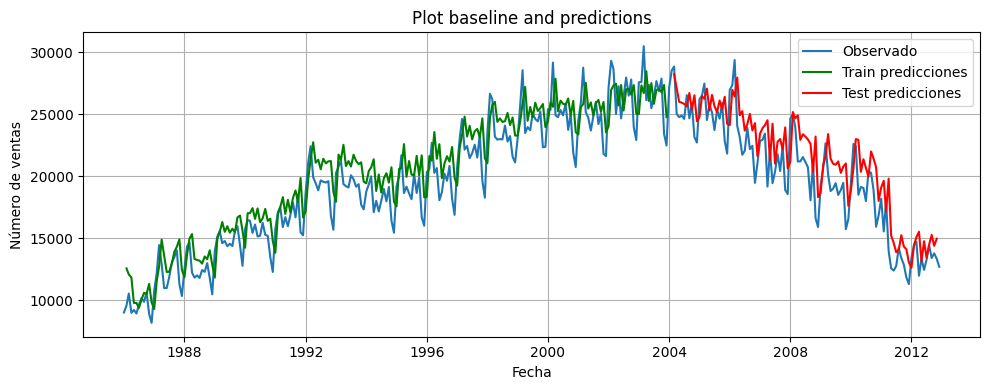

In [23]:
# Hacer un shift de las predicciones de entrenamiento para el plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Hacer un shift de las predicciones de test para el plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(10, 4))
plt.title("Plot baseline and predictions")

# Suponiendo que el índice de dataset es de fechas
fechas = df.index

plt.plot(fechas, scaler.inverse_transform(dataset), label="Observado")
plt.plot(fechas, trainPredictPlot, c="g", label="Train predicciones")
plt.plot(fechas, testPredictPlot, c="r", label="Test predicciones")

plt.ylabel("Número de ventas")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Como podemos ver, la red ha hecho un buen trabajo, aunque las predicciones empiezan a desviarse al final.

---



## Referencias

Este material se ha basado en la entrada ["Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras"](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) de Machine Learning Mastery. Es muy recomendable consultar la entrada completa.